In [1]:
# Downlod the dataset
! rm -rf data
! rm *.csv*
! wget https://storage.googleapis.com/akhilez/datasets/singularity_systems/test_bert.csv
! wget https://storage.googleapis.com/akhilez/datasets/singularity_systems/train_bert.csv
! mkdir -p data
! mv *.csv data/


rm: cannot remove '*.csv*': No such file or directory
--2020-08-01 20:28:42--  https://storage.googleapis.com/akhilez/datasets/singularity_systems/test_bert.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16310138 (16M) [text/csv]
Saving to: ‘test_bert.csv’

test_bert.csv       100%[===================>]  15.55M  52.2MB/s    in 0.3s    

2020-08-01 20:28:43 (52.2 MB/s) - ‘test_bert.csv’ saved [16310138/16310138]

--2020-08-01 20:28:44--  https://storage.googleapis.com/akhilez/datasets/singularity_systems/train_bert.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response...

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Dropout, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
import csv
import numpy as np

In [3]:
class BatchGenerator:

    def __init__(self, data_path, batch_size):
        self.batch_size = batch_size
        self.data_path = data_path
        self.n_labels = 20

    def get_batch_gen(self, repeat=True):
        while True:
            with open(self.data_path) as data_file:
                reader = csv.reader(data_file)
                batch = []
                for row in reader:  # TODO: Can the next batch be fetched asynchronously? With asyncio?
                    batch.append(row)
                    if len(batch) >= self.batch_size:
                        batch = self._split_batch(batch)
                        yield batch
                        batch = []
                if 0 < len(batch) < self.batch_size:
                    yield self._split_batch(batch)
            if not repeat:
                break

    def _split_batch(self, batch):
        batch = np.array(batch, dtype=int)
        x = batch[:, :len(batch[0]) - self.n_labels]
        y = batch[:, len(batch[0]) - self.n_labels:]
        return x, y


In [4]:
train_batch_size = 30
test_batch_size = 30
train_size = 11083
test_size = 7761
train_steps = train_size / train_batch_size
test_steps = test_size / test_batch_size

train_gen = BatchGenerator(data_path='data/train_bert.csv', batch_size=train_batch_size).get_batch_gen()
test_gen = BatchGenerator(data_path='data/test_bert.csv', batch_size=test_batch_size).get_batch_gen()

In [9]:
vocab_size = 30000
embed_size = 128

In [10]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embed_size, input_length=512),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(20, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 128)          3840000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2580      
Total params: 3,859,092
Trainable params: 3,859,092
Non-trainable params: 0
_________________________________________________________________


In [11]:
epochs = 15
history = model.fit(
    train_gen, steps_per_epoch=train_steps, epochs=epochs,
    validation_data=test_gen, validation_steps=test_steps)

Epoch 1/15
370/369 [==============================] - 17s 46ms/step - loss: 2.7180 - accuracy: 0.1587 - val_loss: 2.5138 - val_accuracy: 0.2305
Epoch 2/15
370/369 [==============================] - 17s 46ms/step - loss: 1.8337 - accuracy: 0.4995 - val_loss: 1.7824 - val_accuracy: 0.4836
Epoch 3/15
370/369 [==============================] - 17s 45ms/step - loss: 1.0919 - accuracy: 0.7220 - val_loss: 1.3301 - val_accuracy: 0.5843
Epoch 4/15
370/369 [==============================] - 17s 45ms/step - loss: 0.6880 - accuracy: 0.8333 - val_loss: 1.1014 - val_accuracy: 0.6602
Epoch 5/15
370/369 [==============================] - 17s 45ms/step - loss: 0.4565 - accuracy: 0.8980 - val_loss: 0.9852 - val_accuracy: 0.7013
Epoch 6/15
370/369 [==============================] - 17s 45ms/step - loss: 0.3124 - accuracy: 0.9370 - val_loss: 0.9276 - val_accuracy: 0.7245
Epoch 7/15
370/369 [==============================] - 17s 45ms/step - loss: 0.2185 - accuracy: 0.9598 - val_loss: 0.9057 - val_accuracy:

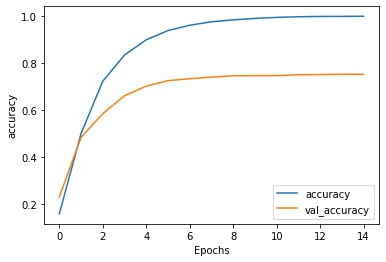

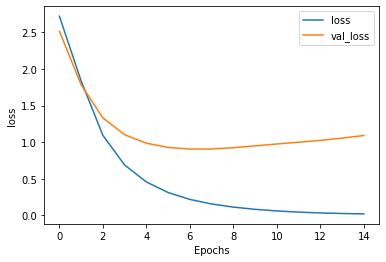

In [12]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


In [13]:
model.save('linear.h5')

In [14]:
from google.colab import files
files.download('linear.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>